In [1]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

[2023-12-09 17:45:51,798] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


2023-12-09 17:45:52.197089: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-09 17:45:52.197125: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-09 17:45:52.197158: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-09 17:45:52.205684: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-09 17:45:53.207978: W tensorflow/c

In [15]:
# df = df.sample(5000)

In [16]:
clip_model.to('cuda:7');

In [35]:
import pandas as pd

df_1 = pd.read_csv('full_meme_data.csv', names=['image', 'description', 'full_description', 'prois', 'meaning'], sep=',')[1:]

In [18]:
# df_1['meaning'].iloc[0]

In [36]:
df_2 = pd.read_csv('vk_memess.csv')

In [38]:
images = df_1['image'].tolist() + df_2['мем'].tolist()

# images = df['allimg']

In [68]:
# len(captions)

In [69]:
captions = df_1['description'].tolist() + df_2['Описание'].tolist()
# captions = df['desc']

# Get images

In [70]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import requests
import urllib3

def download_image(url: str) -> urllib3.response.HTTPResponse:
    raw_image = url
    if url.startswith('http'):
        raw_image = requests.get(url, stream=True).raw
    return raw_image

def download_image_batch(image_urls):
    with ThreadPoolExecutor() as executor:
        futures = []
        for url in image_urls:
            futures.append(executor.submit(download_image, url))
    
        raw_images = []
        for future in as_completed(futures):
            raw_image = future.result()
            if raw_image is not None:
                raw_images.append(raw_image)
    return raw_images

In [71]:
import torch

def return_image_embeddings(images):
    with torch.no_grad():
        inputs = clip_processor(images=images, return_tensors="pt", padding=True).to(clip_model.device)
        embeds = clip_model.get_image_features(**inputs)
    return embeds

In [73]:
import numpy as np
from tqdm import tqdm

total_embeds = []

for batch in tqdm(np.array_split(images, len(images) // 128)):
    raw_images = download_image_batch(batch)
    opened_images = [Image.open(raw_image) for raw_image in raw_images]
    embeds = return_image_embeddings(opened_images)
    total_embeds.append(embeds)

 52% 12/23 [01:17<01:11,  6.47s/it]/usr/local/lib/python3.10/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100% 23/23 [02:38<00:00,  6.88s/it]


In [74]:
total_embeds = torch.cat(total_embeds)

In [75]:
total_embeds.shape

torch.Size([3008, 512])

In [76]:
torch.save(total_embeds, 'weights/images.pt')

In [77]:
total_embeds = torch.load('weights/images.pt')

# Texts

In [78]:
from torch import Tensor, nn
from torch.nn import functional as F

def tensor_masking(tensor: Tensor, mask: Tensor, value: float = 0.0) -> Tensor:
    return tensor.masked_fill((~(mask.bool())).unsqueeze(-1), value)

class GlobalMaskedPooling(nn.Module):
    POOLING_TYPES = ("mean", "max")

    def __init__(
        self,
        pooling_type: str = "mean",
        dim: int = 1,
        normalize: bool = False,
        length_scaling: bool = False,
        scaling_square_root: bool = False,
        embedding_masking: bool = True,
    ):
        super().__init__()

        if dim < 0:
            raise ValueError("Dimension (dim parameter) must be greater than zero")

        self.pooling_type = pooling_type
        self.dim = dim

        self.normalize = normalize
        self.length_scaling = length_scaling
        self.scaling_square_root = scaling_square_root

        self.embedding_masking = embedding_masking

        if self.pooling_type == "max":
            self.mask_value = -float("inf")
        else:
            self.mask_value = 0.0

    def forward(self, tensor: Tensor, pad_mask: Tensor) -> Tensor:
        lengths = pad_mask.sum(self.dim).float()

        if self.embedding_masking:
            tensor = tensor_masking(tensor, pad_mask, value=self.mask_value)

        if self.pooling_type == "mean":
            scaling = tensor.size(self.dim) / lengths
        else:
            scaling = torch.ones(tensor.size(0), device=tensor.device)

        if self.length_scaling:
            lengths_factor = lengths
            if self.scaling_square_root:
                lengths_factor = lengths_factor**0.5
            scaling /= lengths_factor

        scaling = scaling.masked_fill(lengths == 0, 1.0).unsqueeze(-1)

        if self.pooling_type == "mean":
            tensor = tensor.mean(self.dim)
        else:
            tensor, _ = tensor.max(self.dim)

        tensor *= scaling

        if self.normalize:
            tensor = F.normalize(tensor)

        return tensor

mean_pooler = GlobalMaskedPooling(pooling_type='mean')

In [79]:
import torch
from transformers import AutoTokenizer, AutoModel

bert_tokenizer = AutoTokenizer.from_pretrained("cointegrated/LaBSE-en-ru")
bert_model = AutoModel.from_pretrained("cointegrated/LaBSE-en-ru")

In [80]:
bert_model.to('cuda:6');

In [81]:
def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = mean_pooler(model_output.last_hidden_state, t.attention_mask.to(model.device))
    return embeddings

In [82]:
# texts = df['full_description'].tolist() + df_2['Описание'].tolist()

In [52]:
text_embeds = []

for batch in tqdm(np.array_split(captions, len(captions) // 64)):
    model_outputs = embed_bert_cls(list(batch), bert_model, bert_tokenizer)
    text_embeds.append(model_outputs)

100% 47/47 [00:06<00:00,  7.39it/s]


In [53]:
text_embeds = torch.cat(text_embeds)

In [54]:
torch.save(text_embeds, 'weights/texts.pt')

# Dataset

In [83]:
from torch.utils.data import Dataset, DataLoader

class MultiModalDataset(Dataset):
    def __init__(self, captions, images):
        self.captions = captions
        self.images = images
        
    def __len__(self):
        return len(self.captions)
    
    def __getitem__(self, index):
        captions_embedding = self.captions[index]
        image_embedding = self.images[index]
        return captions_embedding, image_embedding

In [84]:
threshold = int(len(text_embeds) * 0.05)

train_dataset = MultiModalDataset(text_embeds[:-threshold], total_embeds[:-threshold])
val_dataset = MultiModalDataset(text_embeds[-threshold:], total_embeds[-threshold:])

In [85]:
len(train_dataset), len(val_dataset)

(2858, 150)

In [86]:
BATCH_SIZE = 128

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=BATCH_SIZE)

# Model

In [87]:
import torch

class MemesCrossEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.image_dim = 512
        self.text_dim = 768

        self.image_proj = torch.nn.Linear(self.image_dim, 512)
        self.text_proj = torch.nn.Linear(self.text_dim, 512)
        self.dropout = torch.nn.Dropout(0.25)

    def forward(self, text_embedding, image_embedding):
        text_embeddings = self.dropout(text_embedding)
        image_embeddings = self.dropout(image_embedding)
        image_emb = self.image_proj(image_embedding)
        text_emb = self.text_proj(text_embedding)

        return image_emb @ text_emb.T

In [88]:
import numpy as np

classifier = MemesCrossEncoder().to('cuda:6')

lr = 1e-5

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)

In [89]:
def loop(classifier, is_training, loader):
    desc = "Training" if is_training else "Evaluating"

    epoch_predictions = list()
    epoch_targets = list()

    epoch_losses = []

    if not is_training:
        classifier.eval()
    else:
        classifier.train()

    for dialogs, images in loader:
        with torch.set_grad_enabled(mode=is_training):
            logits = classifier(dialogs.to(model_device), images.to(model_device)).cpu()

        targets = torch.arange(0, logits.size(0))

        loss = 0.5 * criterion(logits, targets) + 0.5 * criterion(logits.t(), targets)

        epoch_losses.append(loss.item())

        epoch_targets.extend(targets.cpu().tolist())

        if is_training:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(classifier.parameters(), 2)
            optimizer.step()

    epoch_loss = np.mean(epoch_losses)
    return epoch_loss

In [90]:
model_device = 'cuda:6'

EPOCHS = 25

train_losses = list()
train_roc_auc_metrics = list()

valid_losses = list()
valid_roc_auc_metrics = list()

for n_epoch in tqdm(range(EPOCHS)):
    test_loss = loop(classifier=classifier, is_training=False, loader=val_dataloader)
    train_loss = loop(classifier=classifier, is_training=True, loader=train_dataloader)

    train_losses.append(train_loss)
    valid_losses.append(test_loss)

100% 25/25 [00:01<00:00, 14.66it/s]


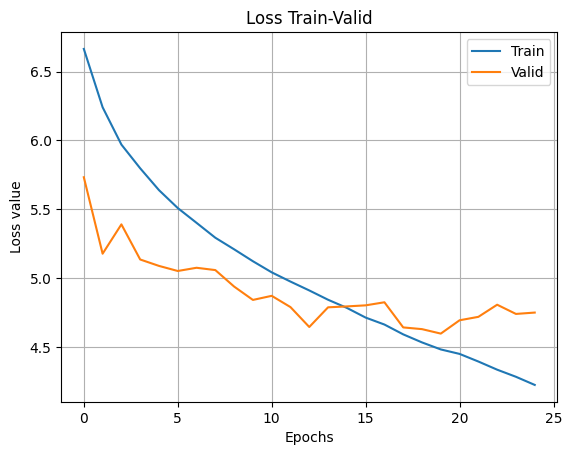

In [91]:
from matplotlib import pyplot as plt

plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.grid()
plt.title("Loss Train-Valid")
plt.plot(train_losses, label="Train")
plt.plot(valid_losses, label="Valid")
plt.legend()

In [92]:
classifier = classifier.eval()

# New inference

In [93]:
with torch.no_grad():
    index_image_embeds = classifier.image_proj(total_embeds.to(model_device))

index_image_embeds = torch.nn.functional.normalize(torch.tensor(index_image_embeds))

/tmp/ipykernel_98087/1121507693.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  index_image_embeds = torch.nn.functional.normalize(torch.tensor(index_image_embeds))


In [94]:
text_embedding = embed_bert_cls("Макеба", bert_model, bert_tokenizer)

with torch.no_grad():
    projected_text_embedding = torch.nn.functional.normalize(classifier.text_proj(text_embedding))

In [95]:
(projected_text_embedding @ index_image_embeds.T).argmax(1)

tensor([1993], device='cuda:6')

In [96]:
captions[1993]

'Призрак в доспехах'

# Inference

In [1020]:
with torch.no_grad():
    index_image_embeds = classifier.image_proj(total_embeds.to(model_device))

index_image_embeds = torch.nn.functional.normalize(torch.tensor(index_image_embeds))

/tmp/ipykernel_68493/1121507693.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  index_image_embeds = torch.nn.functional.normalize(torch.tensor(index_image_embeds))


In [1021]:
import faiss

index = faiss.IndexFlatIP(512) 

index.add(index_image_embeds.cpu().detach().numpy())

In [1022]:
user_query = torch.nn.functional.normalize(embed_bert_cls(text=['шрек'], model=bert_model, tokenizer=bert_tokenizer))

In [1023]:
with torch.no_grad():
    text_emb = classifier.text_proj(user_query).cpu().detach().numpy()

index.search(text_emb, k=20)

(array([[0.07929324, 0.07363001, 0.07238403, 0.07155742, 0.07137875,
         0.07058483, 0.07032125, 0.06911341, 0.06835873, 0.06742298,
         0.06628754, 0.06599209, 0.06559627, 0.0650481 , 0.06500664,
         0.06453533, 0.06447062, 0.06422856, 0.06325899, 0.06325702]],
       dtype=float32),
 array([[2710, 2866,  183,  962, 1150,  563, 1106, 2343, 2110,  205, 1943,
           26,  341,  210,  697, 1238,   48,  851, 2574, 2587]]))

In [1009]:
t = df.iloc[114]

captions[2710]

# print(t['image'])
# print(t['full_description'])

'And so...they were both bottoms итак они обе были пассивами разделение пар по ролям top bottom switch кто сверху снизу две девушки аниме в белье сидят на одной кровати смущаются две лесбиянки неловко готовы заняться сексом но не знают что делать как начать как продолжить неуверенность неуверенные фрейм из манги горит лицо закрывают закрывает лицо лица руками Mikawa Miso Микава Мисо'